<a href="https://colab.research.google.com/github/pratx08/Gen-AI/blob/main/Assignment-5/Janus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Check GPU (optional)
!nvidia-smi || true

# Janus landed in newer Transformers. Pin to a recent version.
!pip -q install --upgrade "transformers>=4.46.0" accelerate safetensors pillow


/bin/bash: line 1: nvidia-smi: command not found


In [25]:
import torch
from transformers import JanusForConditionalGeneration, JanusProcessor
from PIL import Image
from IPython.display import display

# Use the lighter 1B variant for speed; the community repo has working config.
MODEL_ID = "deepseek-community/Janus-Pro-1B"

# Safe dtype logic: bf16 > fp16 (GPU) > fp32 (CPU)
if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
    DTYPE = torch.bfloat16
elif torch.cuda.is_available():
    DTYPE = torch.float16
else:
    DTYPE = torch.float32

DEVICE_MAP = "auto"

print(f"CUDA: {torch.cuda.is_available()} | dtype: {DTYPE} | model: {MODEL_ID}")


CUDA: False | dtype: torch.float32 | model: deepseek-community/Janus-Pro-1B


In [26]:
processor = JanusProcessor.from_pretrained(MODEL_ID)
model = JanusForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    device_map=DEVICE_MAP,
)
model.eval()


`torch_dtype` is deprecated! Use `dtype` instead!


JanusForConditionalGeneration(
  (model): JanusModel(
    (vision_model): JanusVisionModel(
      (embeddings): JanusVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(576, 1024)
      )
      (encoder): JanusVisionEncoder(
        (layers): ModuleList(
          (0-23): 24 x JanusVisionEncoderLayer(
            (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (self_attn): JanusVisionAttention(
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (projection_layer): Linear(in_features=1024, out_features=1024, bias=True)
              (projection_dropout): Identity()
              (q_norm): Identity()
              (k_norm): Identity()
            )
        

Saved: janus_result_0.png


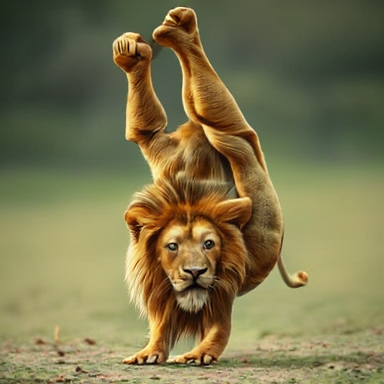

In [27]:
# Edit the prompt; keep it short for speed.
prompt_text = "A realistic lion doing vertical handstand"

# Janus uses a chat template. Build messages then the prompt string:
messages = [{"role": "user", "content": [{"type": "text", "text": prompt_text}]}]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

# Prepare inputs for IMAGE generation
inputs = processor(
    text=prompt,
    generation_mode="image",
    return_tensors="pt"
).to(model.device, dtype=DTYPE)

# One image for speed (you can set 2 if you want two)
model.generation_config.num_return_sequences = 1

with torch.inference_mode():
    outputs = model.generate(
        **inputs,
        generation_mode="image",
        do_sample=True,
        use_cache=True
    )

# Decode tokens → images (PIL)
decoded = model.decode_image_tokens(outputs)
images = processor.postprocess(list(decoded.float()), return_tensors="PIL.Image.Image")

for i, im in enumerate(images["pixel_values"]):
    fname = f"janus_result_{i}.png"
    im.save(fname)
    print("Saved:", fname)
    display(im)
